In [2]:
import scipy.io as scio
import numpy as np 
from skimage import io 
import cv2 
import matplotlib.pyplot as plt 
from skimage import color 

img_folder_path = '/data_disk1/Synth/SynthText'

file_path = '/data_disk1/Synth/SynthText/charBB.npy'

charBB =  np.load(file_path, allow_pickle=True)

img_name_path = '/data_disk1/Synth/SynthText/imnames.npy'

imnames = np.load(img_name_path, allow_pickle=True)

imnames = imnames[0]
charBB = charBB[0]

In [3]:
file_path = '/data_disk1/Synth/SynthText/charBB.npy'

charBB_full =  np.load(file_path, allow_pickle=True)

In [4]:
#Transpose  xy , 4point , bbox  -> bbox , 4point, xy 
charBB = charBB[0].transpose((2,1,0))

In [5]:
first  = cv2.imread(img_folder_path + '/' + imnames[0][0])

In [11]:
cv2.imread(img_folder_path + '/' + imnames[0][0]).shape[0:2]

(419, 600)

In [8]:
#hmmm.....
def generate_gt(img_size , heatmap  , bbox_cor): 

    #bbox_cor = num_bbox , 4point , (x,y)

    row = img_size[0]
    col = img_size[1]

    gt_image = np.zeros((row, col) , np.float32)

    original_cor = np.float32(  [ [0,0] , [0, heatmap.shape[0]] , [heatmap.shape[1],0] , [heatmap.shape[1],heatmap.shape[0]]  ] )

    for bbox in bbox_cor: 

        bbox = np.float32( [bbox[0] , bbox[1] , bbox[3] , bbox[2] ])

        mtrx = cv2.getPerspectiveTransform(original_cor , bbox)
        dst = cv2.warpPerspective( heatmap, mtrx , (col, row) )

        gt_image += dst 
    
    return gt_image 


In [212]:
heatmap = np.load('/root/craft_re/sample_image/gaussian_heatmap/sample_heatmap.npy')
sample_gt = generate_gt(img_size=(img_.shape[0] , img_.shape[1]) , heatmap=heatmap , bbox_cor = charBB )

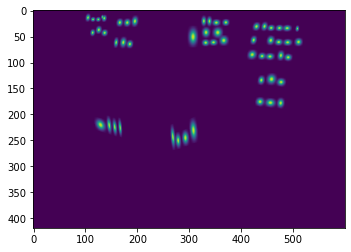

In [213]:
plt.imshow(sample_gt)

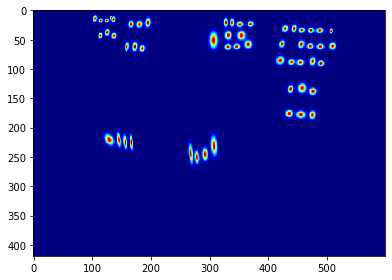

In [218]:
sample_gt = generate_gt(img_size=(img_.shape[0] , img_.shape[1]) ,heatmap=heatmap , bbox_cor = charBB )
sample_gt = sample_gt*255
sample_gt = sample_gt.astype(np.uint8)
sample_gt = cv2.applyColorMap(sample_gt, cv2.COLORMAP_JET)
sample_gt = cv2.cvtColor(sample_gt, cv2.COLOR_BGR2RGB)

img_ = cv2.cvtColor(img_ , cv2.COLOR_BGR2RGB)

io.imshow(sample_gt)

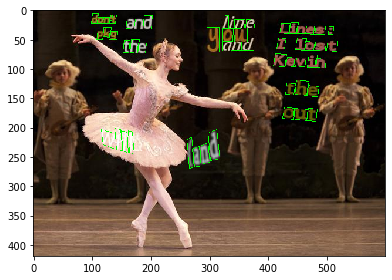

In [219]:
io.imshow(img_)

In [14]:
#Save result 
#io.imsave('/root/craft_re/sample_image/gt/bbox.jpg' , img_)
#io.imsave('/root/craft_re/sample_image/gt/region_score.jpg' , sample_gt)

In [246]:
new = cv2.addWeighted(img_ , 0.3 , sample_gt , 0.7 , 0)

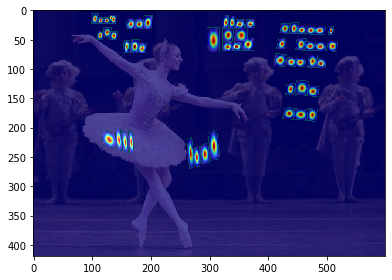

In [247]:
io.imshow(new)
io.imsave('/root/craft_re/sample_image/gt/sample_4.jpg' , new)

In [17]:
charBB.shape

(54, 4, 2)

In [18]:
wordBB_ori = np.load('/data_disk1/Synth/SynthText/wordBB.npy', allow_pickle=True)
txt_ori = np.load('/data_disk1/Synth/SynthText/txt.npy' , allow_pickle=True)

In [19]:
wordBB_full = wordBB_ori[0]
wordBB_first = wordBB_full[0].transpose((2,1,0))

txt_full = txt_ori[0]
txt_first = txt_full[0]

In [23]:
# \n , 공백 -> 이 포함되면 나눠줘야 한다.

In [26]:
#txt 공백제거 
def rm_blank(x): 
    tmp = []
    for word in x: 
        tmp.extend(re.split(' |\n', word))
    # <U19 타입 
    tmp = np.array(tmp , dtype = '<U19')
    tmp = np.delete(tmp, np.where(tmp==''))
    return tmp
    
#txt 파일 공백제거 후 현재위치에 저장 
def save_txt_without_blank(txt_full):
    txt_without_blank = np.empty(txt_full.shape[0] , dtype=object)
    for index, txt in enumerate(txt_full):
        txt_without_blank[index] = rm_blank(txt)
    
    return txt_without_blank
    #np.save(os.getcwd + '/' + 'txt_without_blank' , txt_without_blank)
    

In [36]:
#Save txt_without_blank
#txt_without_blank = save_txt_without_blank(txt_full)
#np.save('./txt_without_blank' , txt_without_blank)

In [37]:
txt_without_blank.shape

(858750,)

In [35]:
#Affinty score를 구해야하는 바운딩박스의 인덱스를 구하는 로직 
index = 0 
index_list = []
for word_lenth in a: 
    if word_lenth == 1: 
        index += 1 
    else: 
        for _ in range(word_lenth-1):
            index_list.append(index)
            index += 1 
        index += 1 

a =  [ 1, 1 ,1 ,2, 1 , 1, 1 , 2 ]
#3,8 -> 3~4 , 8~9 사이의 Affinity를 구하면된다. 
index_list 

[3, 8]

In [51]:
# txt_without_blank -> Affinity_bounding_box index 
# 이 함수를 통해 나온 어레이에 있는 index , index+1 사이의 Affinity를 구하면된다. 
def make_Affinity_index(txt_without_blank):
    Affinity_index_list = np.empty(txt_without_blank.shape[0] , dtype=object)
    for n , txt in  enumerate(txt_without_blank):
        index_list = np.array([] , dtype=np.int32)
        index = 0 
        for word in txt: 
            if len(word) == 1: 
                index += 1 
            else: 
                for _ in range(len(word) - 1 ):
                    index_list = np.append(index_list , index)
                    index += 1 
                index += 1 
        Affinity_index_list[n] = index_list
    return Affinity_index_list 



In [59]:
#Save Affinity index 
#Affinity_index = make_Affinity_index(txt_without_blank=txt_without_blank)
#np.save('./Affinity_index' , Affinity_index )

In [193]:
#Affinity box 의 좌표 생성 
#사각형의 대각선 교점을 구해야하는데 직접 구하면 너무 복잡해서 
#4개 좌표의 평균값으로 근사한다. -> 사각형이 정/직사각형, 평행사변형 이면 일치한다. 
def affinity_box(bbox1 , bbox2):
    #Aproximation of center of square 
    center1 = np.mean(bbox1 , axis = 0 )
    center2 = np.mean(bbox2 , axis = 0)

    #4 triangular 
    left_top = (bbox1[0] + bbox1[1] + center1)/3
    left_bottom = (bbox1[2] + bbox1[3] + center1)/3
    right_top = (bbox2[0] + bbox2[1] + center2)/3
    right_bottom = (bbox2[2] + bbox2[3] + center2)/3

    return np.array([left_top , right_top , right_bottom , left_bottom])

#Affinity_index를 받아서 Affinity_box 좌표를 저장 
#affinity_index = (num of images , )
#charBB = (num of images, )
def affinity_box_list(affinity_index , charBB):
    #empty affinityBB
    affinityBB = np.empty(affinity_index.shape[0], dtype=object)

    for image_index in range(affinity_index.shape[0]):

        image_BB = np.empty((affinity_index[image_index].shape[0],4,2) , dtype=object)

        t_charBB = charBB[image_index].transpose(2,1,0)

        for index , affinity_index_ in enumerate(affinity_index[image_index]):

            aff_bbox = affinity_box(t_charBB[affinity_index_] , t_charBB[affinity_index_ + 1])

            image_BB[index] = aff_bbox

        affinityBB[image_index] = image_BB

    return affinityBB


In [194]:
Affinity_index = make_Affinity_index(txt_without_blank[0:2])
ac = charBB_full[0][0:2]

In [195]:
sam = affinity_box_list(Affinity_index , ac)

In [206]:
sam.shape

(2,)

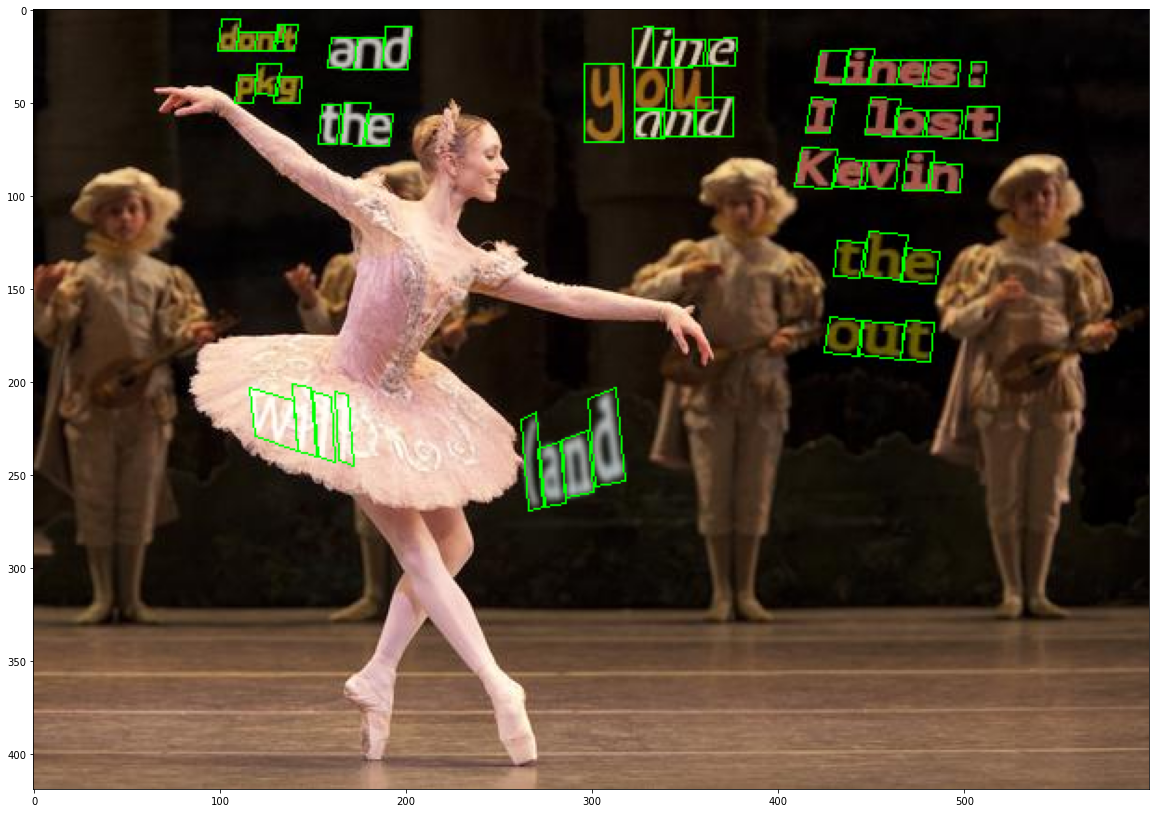

In [248]:
#Region Bounding box 
img_ = cv2.imread(img_folder_path + '/' + imnames[0][0])
for bbox in charBB:
    img_  = cv2.polylines(img_ , [bbox.astype(np.int32)], isClosed = True , color = (0,255,0) , thickness=1)

img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20,20))
plt.imshow(img_)

#io.imsave('/root/craft_re/sample_image/gt/sample_1.jpg' , img_)


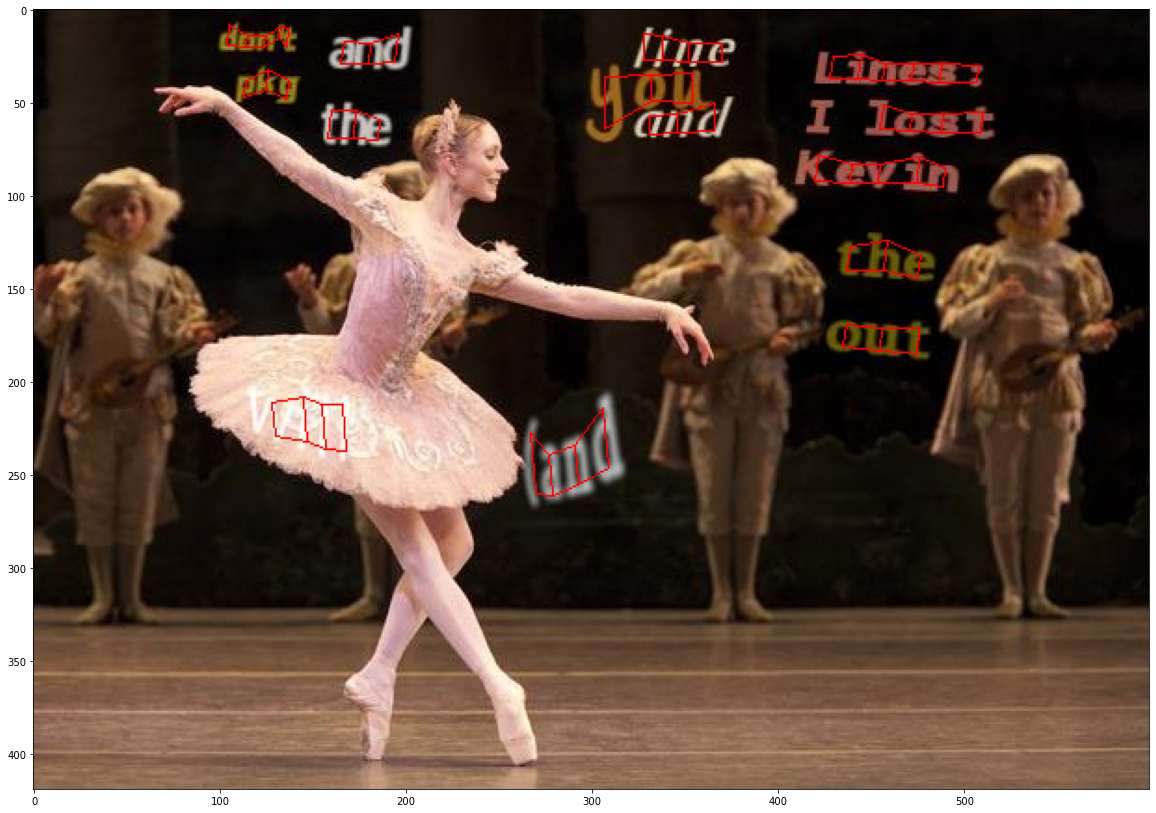

In [236]:
#Affinity Bounding box 
img_ = cv2.imread(img_folder_path + '/' + imnames[0][0])
for aff_bbox in sam[0]:
    img_ = cv2.polylines(img_ , [aff_bbox.astype(np.int32)], isClosed = True , color = (0,0,255), thickness = 1)

img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.imshow(img_)

#io.imsave('/root/craft_re/sample_image/gt/sample_2.jpg' , img_)

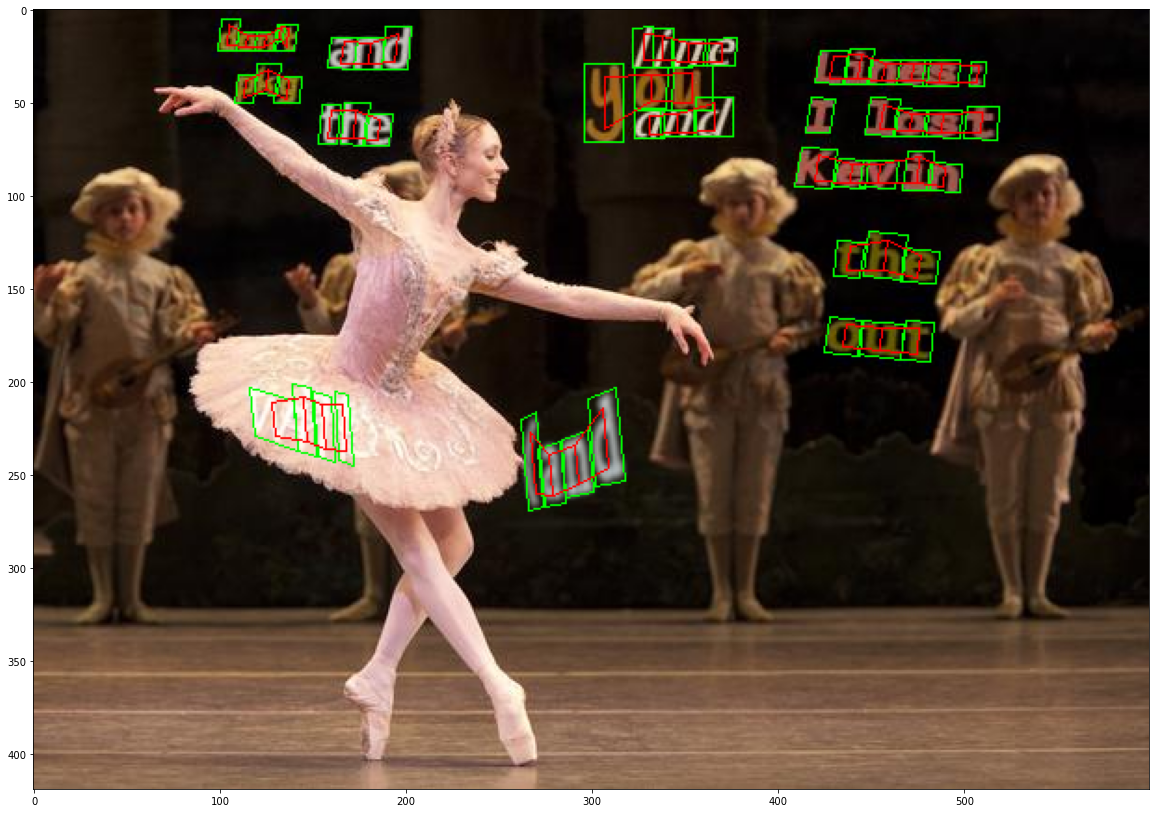

In [238]:
#Region + Affinity Bounding box 
img_ = cv2.imread(img_folder_path + '/' + imnames[0][0])
for bbox in charBB:
    img_  = cv2.polylines(img_ , [bbox.astype(np.int32)], isClosed = True , color = (0,255,0) , thickness=1)
for aff_bbox in sam[0]:
    img_ = cv2.polylines(img_ , [aff_bbox.astype(np.int32)], isClosed = True , color = (0,0,255), thickness = 1)

img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.imshow(img_)

#io.imsave('/root/craft_re/sample_image/gt/sample_3.jpg' , img_)

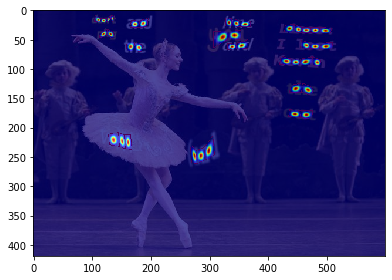

In [240]:
img_ = cv2.imread(img_folder_path + '/' + imnames[0][0])
for aff_bbox in sam[0]:
    img_ = cv2.polylines(img_ , [aff_bbox.astype(np.int32)], isClosed = True , color = (0,0,255), thickness = 1)

img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)


sample_affinity_gt = generate_gt(img_size=(img_.shape[0] , img_.shape[1]) ,heatmap=heatmap , bbox_cor = sam[0] )
sample_affinity_gt = sample_affinity_gt*255
sample_affinity_gt = sample_affinity_gt.astype(np.uint8)
sample_affinity_gt = cv2.applyColorMap(sample_affinity_gt, cv2.COLORMAP_JET)
sample_affinity_gt = cv2.cvtColor(sample_affinity_gt, cv2.COLOR_BGR2RGB)

img_ = cv2.addWeighted(img_ , 0.3 , sample_affinity_gt , 0.7 , 0)

io.imshow(img_)

#io.imsave('/root/craft_re/sample_image/gt/sample_5.jpg' , img_)